<a href="https://colab.research.google.com/github/JohnTichenor/Locating-Bacterial-Flagellar-Motors/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

## Import Dependencies

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [4]:
TRAIN_DIR = "/content/drive/MyDrive/BacterialFlagellarMotorsData/train"
TEST_DIR = "/content/drive/MyDrive/BacterialFlagellarMotorsData/test"
LABELS_PATH = "/content/drive/MyDrive/BacterialFlagellarMotorsData/train_labels.csv"
SUBMIT_PATH = "/content/drive/MyDrive/BacterialFlagellarMotorsData/submission.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create Bounding Boxes

In [5]:
import pandas as pd
import json
import os

def create_motor_bounding_boxes(csv_path, output_json_path, box_size=32):
    """
    Convert 3D motor coordinates into 2D bounding boxes and save as JSON.

    Args:
        csv_path (str): Path to the CSV file with motor annotations.
        output_json_path (str): Path to save the output JSON file.
        box_size (int): Width/height of the bounding box (in pixels). Default is 32.

    Returns:
        str: Path to the saved JSON file.
    """

    if os.path.exists(output_json_path):
        print(f"⚠️ JSON already exists at '{output_json_path}'. Skipping creation.")
        return output_json_path

    df = pd.read_csv(csv_path)
    half = box_size // 2
    bbox_dict = {}

    for _, row in df.iterrows():
        z = row["Motor axis 0"]
        y = row["Motor axis 1"]
        x = row["Motor axis 2"]
        tomo_id = row["tomo_id"]

        # Skip entries with invalid motor position
        if z < 0 or x < 0 or y < 0:
            continue

        # Construct the image filename (e.g. tomo_00e047/slice_0169.jpg)
        image_filename = f"{tomo_id}/slice_{int(z):04d}.jpg"

        # Compute bounding box coordinates centered at (x, y)
        xmin = max(0, int(x - half))
        ymin = max(0, int(y - half))
        xmax = int(x + half)
        ymax = int(y + half)

        # Append annotation
        bbox = [xmin, ymin, xmax, ymax]
        label = 1  # Only one class: motor

        if image_filename not in bbox_dict:
            bbox_dict[image_filename] = []

        bbox_dict[image_filename].append({"bbox": bbox, "label": label})

    # Write to JSON
    with open(output_json_path, "w") as f:
        json.dump(bbox_dict, f, indent=2)

    return output_json_path


# Bounding Box Output Path "bounding_boxes_<box_size>.json"
bounding_boxes_json = "/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json"

create_motor_bounding_boxes(LABELS_PATH, bounding_boxes_json, box_size=32)

⚠️ JSON already exists at '/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json'. Skipping creation.


'/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json'

## Draw Boxes

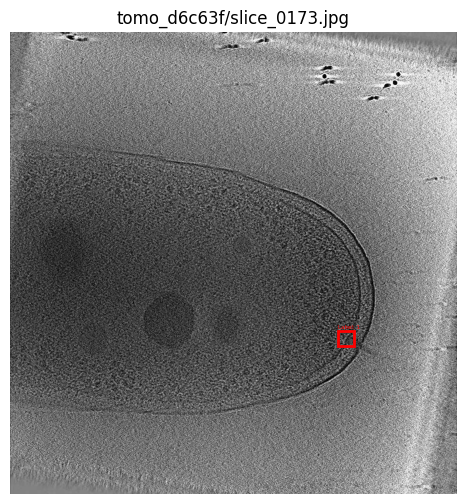

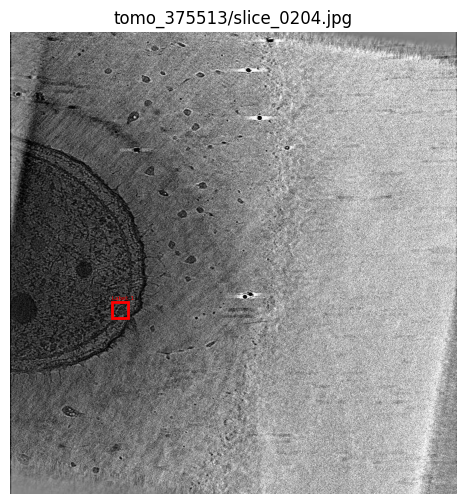

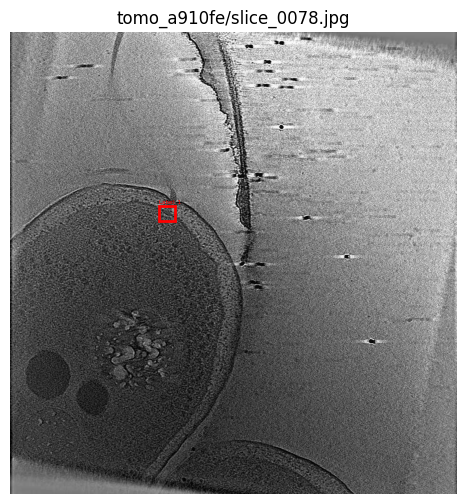

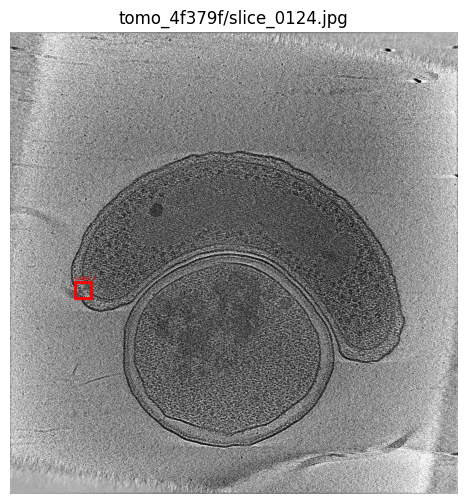

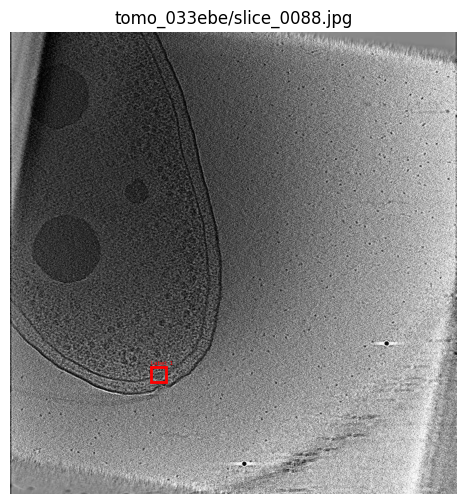

In [6]:
import json
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

def visualize_bounding_boxes(json_path, root_dir, n=5):
    """
    Visualize bounding boxes from JSON on randomly selected image slices.

    Args:
        json_path (str): Path to the JSON file containing bounding boxes.
        root_dir (str): Root directory containing image folders (e.g., tomo_id/slice_xxxx.jpg).
        n (int): Number of images to visualize.
    """
    # Load the bounding box annotations
    with open(json_path, "r") as f:
        bbox_dict = json.load(f)

    # Select random N image filenames
    image_files = random.sample(list(bbox_dict.keys()), min(n, len(bbox_dict)))

    for img_rel_path in image_files:
        img_path = os.path.join(root_dir, img_rel_path)
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        ax = plt.gca()

        # Draw bounding boxes
        for ann in bbox_dict[img_rel_path]:
            xmin, ymin, xmax, ymax = ann["bbox"]
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Label: {ann['label']}", color='red', fontsize=4)

        plt.title(img_rel_path)
        plt.axis("off")
        plt.show()

visualize_bounding_boxes(
    json_path=bounding_boxes_json,
    root_dir=TRAIN_DIR,
    n=5  # View 5 images
)


# Format the Dataset

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class TomogramDataset(Dataset):
    def __init__(self, root_dir, json_path, transforms=None):
        """
        root_dir: path to the folder containing tomogram subfolders
        json_path: bounding box annotations (from motor_bounding_boxes.json)
        """
        self.root_dir = root_dir
        self.transforms = transforms

        with open(json_path) as f:
            self.annotations = json.load(f)

        self.image_paths = list(self.annotations.keys())  # e.g., tomo_00e047/slice_0169.jpg

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        image = Image.open(img_path).convert("RGB")

        boxes = torch.tensor([ann["bbox"] for ann in self.annotations[rel_path]], dtype=torch.float32)
        labels = torch.tensor([ann["label"] for ann in self.annotations[rel_path]], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [8]:
from torchvision import transforms

# Your custom dataset
dataset = TomogramDataset(
    root_dir=TRAIN_DIR,
    json_path=bounding_boxes_json,
    transforms=transforms.ToTensor()
)

# Dataloader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

### Define the Model

In [9]:
# Load a pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classification head
num_classes = 2  # 1 motor class + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model on GPU
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Main

In [10]:
!pip install tqdm

In [11]:
from tqdm import tqdm

# Some HP
num_epochs = 10
lr = 0.005

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"[Epoch {epoch + 1}/{num_epochs}] Loss: {total_loss:.4f}")



[Epoch 1/10] Loss: 16.5747


[Epoch 2/10] Loss: 16.0539


[Epoch 3/10] Loss: 13.3026


[Epoch 4/10] Loss: 10.5485


[Epoch 5/10] Loss: 8.9325


[Epoch 6/10] Loss: 7.7718


[Epoch 7/10] Loss: 6.9431


[Epoch 8/10] Loss: 6.3223


[Epoch 9/10] Loss: 6.2485


[Epoch 10/10] Loss: 6.1128


## Save Model

In [16]:
torch.save(model.state_dict(), "/content/drive/MyDrive/BacterialFlagellarMotorsData/fasterrcnn_motor_detector.pth")


## Run Inference

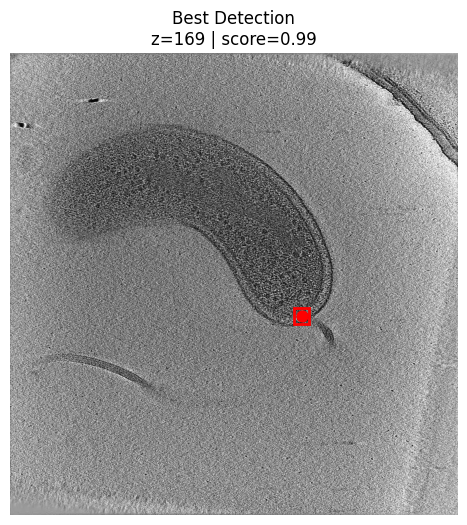

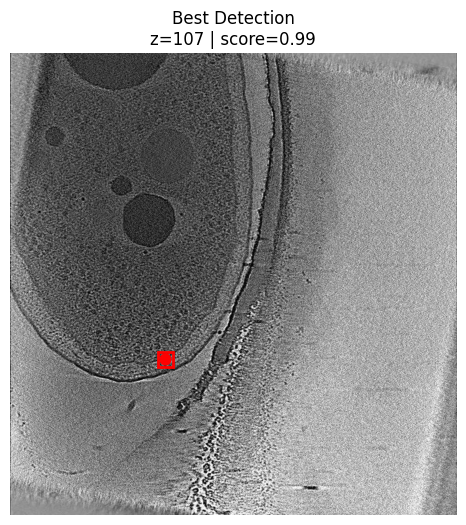

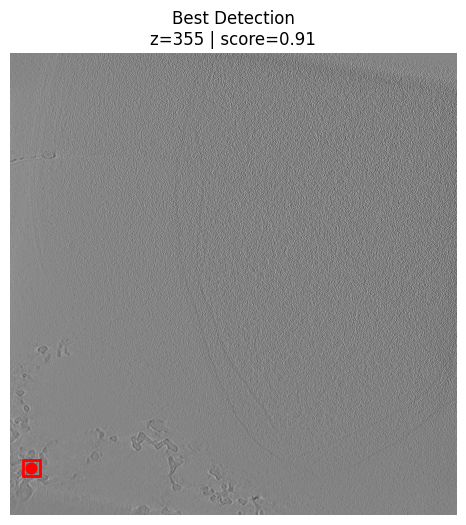

In [47]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def infer_motor_location(model, tomo_dir, device='cpu', score_threshold=0.5, show=True):
    """
    Infers the most likely motor location from a 3D tomogram and optionally visualizes it.

    Args:
        model (torch.nn.Module): Trained Faster R-CNN model.
        tomo_dir (str): Path to folder containing slice_XXXX.jpg images.
        device (str): 'cuda' or 'cpu'.
        score_threshold (float): Minimum score to accept a detection.
        show (bool): Whether to visualize the top detection.

    Returns:
        dict: Detection info or a message if none found.
    """
    model.to(device)
    model.eval()

    transform = transforms.ToTensor()
    best_detection = None
    best_image = None

    for slice_file in sorted(os.listdir(tomo_dir)):
        if not slice_file.endswith(".jpg"):
            continue

        try:
            z_index = int(slice_file.split("_")[1].split(".")[0])
        except Exception:
            continue

        img_path = os.path.join(tomo_dir, slice_file)
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_tensor)[0]

        for box, score in zip(outputs["boxes"], outputs["scores"]):
            if score >= score_threshold:
                xmin, ymin, xmax, ymax = box.tolist()
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2

                detection = {
                    "slice": slice_file,
                    "Motor axis 0": z_index,
                    "Motor axis 1": y_center,
                    "Motor axis 2": x_center,
                    "score": float(score),
                    "bbox": [xmin, ymin, xmax, ymax]
                }

                if best_detection is None or score > best_detection["score"]:
                    best_detection = detection
                    best_image = image.copy()

    if best_detection and show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(best_image)
        xmin, ymin, xmax, ymax = best_detection["bbox"]
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor='red', linewidth=2, fill=False))
        ax.scatter(best_detection["Motor axis 2"], best_detection["Motor axis 1"], color='red', s=60)
        ax.set_title(f"Best Detection\nz={best_detection['Motor axis 0']} | score={best_detection['score']:.2f}")
        plt.axis("off")
        plt.show()

    return best_detection if best_detection else {"message": "No confident detections found."}


# Test
test_1 = TEST_DIR + "/tomo_00e047"
test_1_inference = infer_motor_location(model, test_1, device=device)

test_2 = TEST_DIR + "/tomo_01a877"
test_2_inference = infer_motor_location(model, test_2, device=device)

test_3 = TEST_DIR + "/tomo_003acc"
test_3_inference = infer_motor_location(model, test_3, device=device)



## Put Test Inference Into a DF

In [48]:
# Add folder names
test_1_inference["tomo_id"] = os.path.basename(test_1)
test_2_inference["tomo_id"] = os.path.basename(test_2)
test_3_inference["tomo_id"] = os.path.basename(test_3)

# Convert to DataFrame
inference_results = [test_1_inference, test_2_inference, test_3_inference]
submission_df = pd.DataFrame(inference_results)

# Display
print(submission_df)

            slice  Motor axis 0  Motor axis 1  Motor axis 2     score  \
0  slice_0169.jpg           169    545.461975    604.739227  0.993455   
1  slice_0107.jpg           107    636.333313    322.442322  0.991984   
2  slice_0355.jpg           355   1718.355652     87.877851  0.907205   

                                                bbox      tomo_id  
0  [588.7193603515625, 529.4449462890625, 620.759...  tomo_00e047  
1  [307.1749572753906, 620.6261596679688, 337.709...  tomo_01a877  
2  [54.12569808959961, 1685.9010009765625, 121.63...  tomo_003acc  


## Put True Test Into a DF

In [49]:
# Load your full CSV (e.g. ground truth or solution)
solution_df = pd.read_csv(LABELS_PATH)

# Filter rows where 'tomo_id' matches any in your inference df
solution_df = solution_df[solution_df['tomo_id'].isin(submission_df['tomo_id'])]

# Order rows by 'tomo_id'
solution_df = solution_df.set_index('tomo_id').loc[submission_df['tomo_id']].reset_index()

# Change column name Number of motors -> Has motor
solution_df = solution_df.rename(columns={"Number of motors": "Has motor"})


# View or save
print(solution_df)


       tomo_id  row_id  Motor axis 0  Motor axis 1  Motor axis 2  \
0  tomo_00e047       1         169.0         546.0         603.0   
1  tomo_01a877       8         147.0         638.0         286.0   
2  tomo_003acc       0          -1.0          -1.0          -1.0   

   Array shape (axis 0)  Array shape (axis 1)  Array shape (axis 2)  \
0                   300                   959                   928   
1                   300                   960                   928   
2                   500                  1912                  1847   

   Voxel spacing  Has motor  
0           15.6          1  
1           13.1          1  
2            6.5          0  


## Prepare DFs to Evaluate

In [50]:
import pandas as pd

def standardize_and_validate_columns(solution_df, submission_df):
    expected_solution_cols = [
        "tomo_id", "Motor axis 0", "Motor axis 1", "Motor axis 2", "Voxel spacing", "Has motor"
    ]
    expected_submission_cols = [
        "tomo_id", "Motor axis 0", "Motor axis 1", "Motor axis 2"
    ]

    # Filter to only the expected columns (if extras exist)
    solution_df = solution_df[expected_solution_cols].copy()
    submission_df = submission_df[expected_submission_cols].copy()

    # Validate that all required columns exist
    if not all(col in solution_df.columns for col in expected_solution_cols):
        raise ValueError("Missing required columns in solution DataFrame")

    if not all(col in submission_df.columns for col in expected_submission_cols):
        raise ValueError("Missing required columns in submission DataFrame")

    return solution_df, submission_df

solution_df, submission_df = standardize_and_validate_columns(solution_df, submission_df)

print(solution_df)
print(submission_df)


       tomo_id  Motor axis 0  Motor axis 1  Motor axis 2  Voxel spacing  \
0  tomo_00e047         169.0         546.0         603.0           15.6   
1  tomo_01a877         147.0         638.0         286.0           13.1   
2  tomo_003acc          -1.0          -1.0          -1.0            6.5   

   Has motor  
0          1  
1          1  
2          0  
       tomo_id  Motor axis 0  Motor axis 1  Motor axis 2
0  tomo_00e047           169    545.461975    604.739227
1  tomo_01a877           107    636.333313    322.442322
2  tomo_003acc           355   1718.355652     87.877851


## BYU Evaluation Metric

In [52]:
import sklearn.metrics
import numpy as np


class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def distance_metric(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    thresh_ratio: float,
    min_radius: float,
):
    coordinate_cols = ['Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    label_tensor = solution[coordinate_cols].values.reshape(len(solution), -1, len(coordinate_cols))
    predicted_tensor = submission[coordinate_cols].values.reshape(len(submission), -1, len(coordinate_cols))
    # Find the minimum euclidean distances between the true and predicted points
    solution['distance'] = np.linalg.norm(label_tensor - predicted_tensor, axis=2).min(axis=1)
    # Convert thresholds from angstroms to voxels
    solution['thresholds'] = solution['Voxel spacing'].apply(lambda x: (min_radius * thresh_ratio) / x)
    solution['predictions'] = submission['Has motor'].values
    solution.loc[(solution['distance'] > solution['thresholds']) & (solution['Has motor'] == 1) & (submission['Has motor'] == 1), 'predictions'] = 0
    return solution['predictions'].values

def score(solution: pd.DataFrame, submission: pd.DataFrame, min_radius: float, beta: float) -> float:
    """
    Parameters:
    solution (pd.DataFrame): DataFrame containing ground truth motor positions.
    submission (pd.DataFrame): DataFrame containing predicted motor positions.

    Returns:
    float: FBeta score.

    Example
    --------
    >>> solution = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [-1, 250, 100, 200],
    ...     'Motor axis 1': [-1, 250, 100, 200],
    ...     'Motor axis 2': [-1, 250, 100, 200],
    ...     'Voxel spacing': [10, 10, 10, 10],
    ...     'Has motor': [0, 1, 1, 1]
    ... })
    >>> submission = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [100, 251, 600, -1],
    ...     'Motor axis 1': [100, 251, 600, -1],
    ...     'Motor axis 2': [100, 251, 600, -1]
    ... })
    >>> score(solution, submission, 1000, 2)
    0.3571428571428571
    """

    solution = solution.sort_values('tomo_id').reset_index(drop=True)
    submission = submission.sort_values('tomo_id').reset_index(drop=True)

    filename_equiv_array = solution['tomo_id'].eq(submission['tomo_id'], fill_value=0).values

    if np.sum(filename_equiv_array) != len(solution['tomo_id']):
        raise ValueError('Submitted tomo_id values do not match the sample_submission file')

    submission['Has motor'] = 1
    # If any columns are missing an axis, it's marked with no motor
    select = (submission[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']] == -1).any(axis='columns')
    submission.loc[select, 'Has motor'] = 0

    cols = ['Has motor', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    assert all(col in submission.columns for col in cols)

    # Calculate a label of 0 or 1 using the 'has motor', and 'motor axis' values
    predictions = distance_metric(
        solution,
        submission,
        thresh_ratio=1.0,
        min_radius=min_radius,
    )

    return sklearn.metrics.fbeta_score(solution['Has motor'].values, predictions, beta=beta)

score_value = score(solution_df, submission_df, min_radius=1000, beta=2)
print(f"F2 Score: {score_value:4f}")


F2 Score: 0.909091
